# Step 1: El simple y viejo Train / Test

In [1]:
# Limpiamos el entorno
rm(list = ls())
gc(verbose = FALSE)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,627610,33.6,1404605,75.1,994513,53.2
Vcells,1149698,8.8,8388608,64.0,1769393,13.5


In [2]:
install.packages("caret")

Installing package into 'C:/Users/German/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'caret' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'caret'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\German\AppData\Local\R\win-library\4.3\00LOCK\caret\libs\x64\caret.dll  a C:\Users\German\AppData\Local\R\win-library\4.3\caret\libs\x64\caret.dll: Permission denied"
Warning message:
"restored 'caret'"



The downloaded binary packages are in
	C:\Users\German\AppData\Local\Temp\RtmpkzRw7B\downloaded_packages


In [3]:
# Librerías necesarias
require("data.table")
require("rpart")
require("ROCR")
require("ggplot2")
require("caret")

Loading required package: data.table



Loading required package: rpart

Loading required package: ROCR

Loading required package: ggplot2

Loading required package: caret

Loading required package: lattice



In [4]:
# Aqui se debe poner la carpeta de la materia de SU computadora local
setwd("C:/Users/German/Desktop/dmeyf2023/German/Clase 1") # Establezco el Working Directory

# Poner sus semillas
semillas <- c(279511, 279523, 279541, 279551, 279571)

# Cargamos el dataset
dataset <- fread("competencia_01.csv")
dtrain <- dataset[foto_mes == 202103]

In [5]:
# Nos quedamos solo con el 202101
dataset <- dataset[foto_mes == 202103]
# Creamos una clase binaria
dataset[, clase_binaria := ifelse(
                            clase_ternaria == "BAJA+2",
                                "evento",
                                "noevento"
                            )]
# Borramos el target viejo
dataset[, clase_ternaria := NULL]

In [6]:
# Seteamos nuestra primera semilla
set.seed(semillas[1])

In [7]:
# Particionamos de forma estratificada
in_training <- caret::createDataPartition(dataset$clase_binaria,
                     p = 0.70, list = FALSE) 
dtrain  <-  dataset[in_training, ]
dtest   <-  dataset[-in_training, ]

 Preguntas
 - ¿Por qué separamos en train/test?
 - ¿Son números aleatorios los que nos dan las computadoras?
 - ¿Por qué usamos semillas?
 - ¿Qué es una partición estratificada?
 - ¿Tiene realemente alguna ventaja la partición estratificada ?

# Step 2: Armando el primer modelo particionado

In [8]:
# Medimos cuanto tarda nuestro modelo en ajustar
start_time <- Sys.time()
modelo <- rpart(clase_binaria ~ .,
                data = dtrain,
                xval = 0,
                cp = 0,
                minsplit = 20,
                minbucket = 1,
                maxdepth = 5)
print(Sys.time() - start_time)

Time difference of 4.08364 secs


In [9]:
pred_testing <- predict(modelo, dtest, type = "prob")

 Preguntas:
 - ¿Qué tan importante mirar las métricas de train?

# Step 3: Mirando la ganancia

In [10]:
# Armamos una función que nos calcule la ganancia, usando el punto de corte de 0.025
ganancia <- function(probabilidades, clase) {
  return(sum(
    (probabilidades >= 0.025) * ifelse(clase == "evento", 273000, -7000))
  )
}

In [11]:
# La ganancia en testing NORMALIZADA
print(ganancia(pred_testing[, "evento"], dtest$clase_binaria) / 0.3)

[1] 78960000


`Actividad`:
Comparta el número que le dio de ganancia y cuanto error estima que puede haber con el resto de sus compañeros


# Step 4: Probando más muchas más semillas

In [12]:
# Almacenaremos los resultados en una tabla
resultados_n_gan <- c()

Calcule en función del tiempo de ejecución anterior, cuantos árboles puede hacer en 5 minutos y ponga ese número en la siguiente variable "n"

In [13]:
n <- 100

In [14]:
set.seed(semillas[1])
t0 <- Sys.time()
for (i in 1:n) {

    in_training <- caret::createDataPartition(dataset[, get("clase_binaria")],
                            p = 0.70, list = FALSE)
    dtrain  <-  dataset[in_training, ]
    dtest   <-  dataset[-in_training, ]

    modelo <- rpart(clase_binaria ~ .,
                    data = dtrain,
                    xval = 0,
                    cp = 0,
                    minsplit = 20,
                    minbucket = 1,
                    maxdepth = 5)

    pred_testing <- predict(modelo, dtest, type = "prob")

    gan <- ganancia(pred_testing[, "evento"], dtest$clase_binaria) / 0.3

    resultados_n_gan <- c(resultados_n_gan, gan)
}
print(Sys.time() - t0)


Time difference of 7.399352 mins


 Preguntas:
 ¿Cree que puede cambiar mucho la ganancia en **test** para dos semillas distintas?


# Step 5: Analizando el azar de las semillas

In [15]:
# La menor ganancia conseguida en test
print(min(resultados_n_gan))

# La mayor ganancia
print(max(resultados_n_gan))

# La media de la ganancia
print(mean(resultados_n_gan))

[1] 27930000
[1] 93030000
[1] 72626167


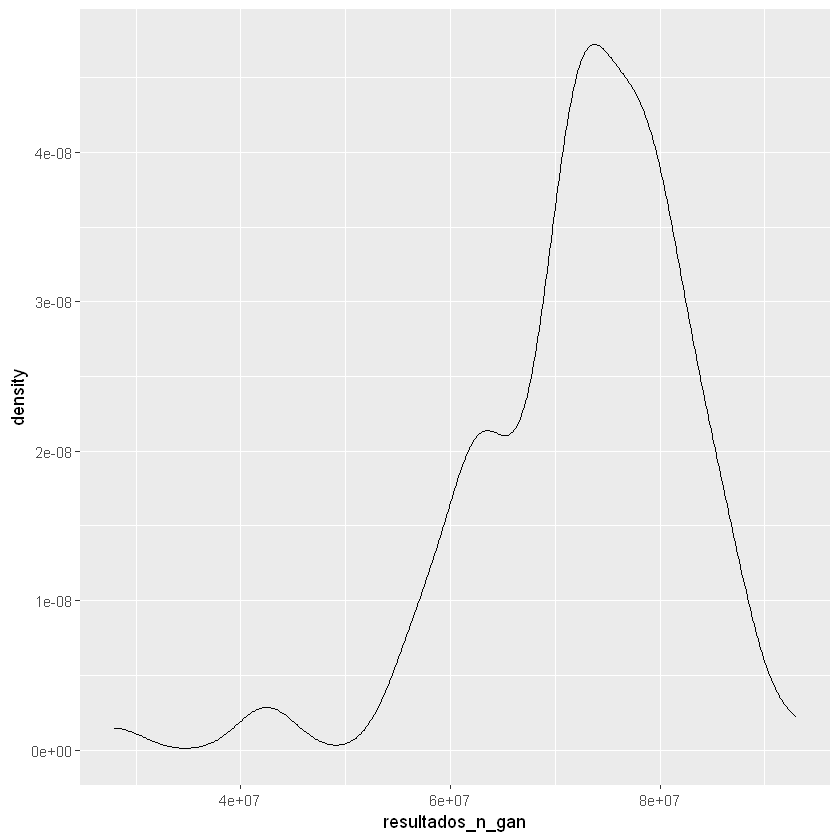

In [16]:
# Veamos la dispersión de la ganancia
ggplot() + aes(resultados_n_gan) + geom_density()

# Step 6: Tratando de corregir la dispersión

In [17]:
# Veamos si tomar el promedio de 5 árboles nos ayuda a reducir la dispersión
cantidad_arboles <- 5

resultados_n_mcv <- c()
set.seed(semillas[1])

for (i in 1:50) 
    resultados_n_mcv <- c(resultados_n_mcv, mean(sample(resultados_n_gan, cantidad_arboles)))

In [18]:
# La menor ganancia conseguida en test
print(min(resultados_n_mcv))

# La mayor ganancia
print(max(resultados_n_mcv))

# La media de la ganancia
print(mean(resultados_n_mcv))

[1] 64232000
[1] 80117333
[1] 72339307


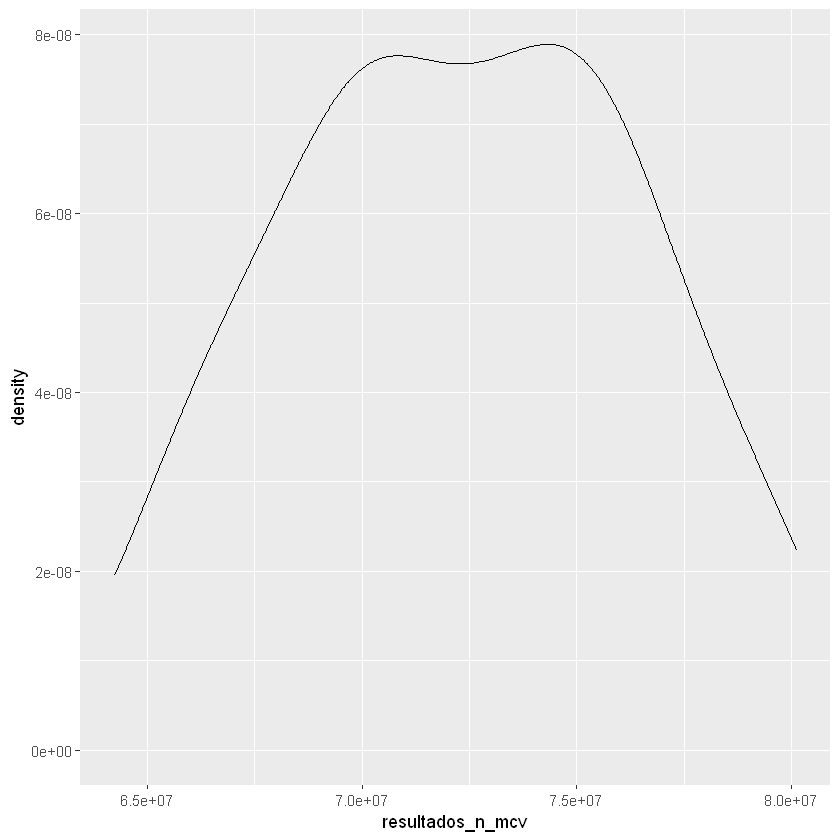

In [19]:
# Veamos la dispersión de la ganancia
ggplot() + aes(resultados_n_mcv) + geom_density()

`NOTA`: Esta técnica es conocida como Montecarlo Cross Validation
 Preguntas
 - ¿Qué efecto observa cuando se toma como medición el promedio de 5 árboles?
 - ¿Desapareció el error?
 - ¿Si se hubieran tomado más valores que efectos esperaría?
 - ¿Que ventaja y desventaja ve en esta técnica comparada al Cross Validation?

# Step 7: Midiendo nuestras semillas

In [20]:
resultados_mis_semillas <- c()

t0 <- Sys.time()
for (s in semillas) {
    set.seed(s)
    in_training <- caret::createDataPartition(dataset[, get("clase_binaria")],
                            p = 0.70, list = FALSE)
    dtrain  <-  dataset[in_training, ]
    dtest   <-  dataset[-in_training, ]

    modelo <- rpart(clase_binaria ~ .,
                    data = dtrain,
                    xval = 0,
                    cp = 0,
                    minsplit = 20,
                    minbucket = 1,
                    maxdepth = 5)

    pred_testing <- predict(modelo, dtest, type = "prob")

    gan <- ganancia(pred_testing[, "evento"], dtest$clase_binaria) / 0.3

    resultados_mis_semillas <- c(resultados_mis_semillas, gan)

}
print(Sys.time() - t0)

Time difference of 21.94387 secs


In [21]:
print(mean(resultados_mis_semillas))

[1] 70396667


Preguntas
 - ¿Cuán lejos se encontró la media de sus semillas respecto a los resultados anteriores?
 - ¿Usaría semillas que le den un valor promedio más alto?
 - ¿Usaría más semillas?
 - ¿Que ventaja y desventaja ve en usar más semillas?

# Step 8: Buscando un mejor modelo (Grid Search)

## Estrategia de la clase

In [22]:
resultados_grid_search <- data.table()

 Complete los valores que se van a combinar para cada parámetro a explorar

In [23]:
for (cp in c(-1, 0.01)) { 
for (md in c(5, 10, 15, 30)) {
for (ms in c(1, 50, 500, 1000)) {
for (mb in c(1, as.integer(ms / 2))) {

    t0 <- Sys.time()
    gan_semillas <- c()
    for (s in semillas) {
        set.seed(s)
        in_training <- caret::createDataPartition(dataset[,
                        get("clase_binaria")],
                                p = 0.70, list = FALSE)
        dtrain  <-  dataset[in_training, ]
        dtest   <-  dataset[-in_training, ]

        modelo <- rpart(clase_binaria ~ .,
                        data = dtrain,
                        xval = 0,
                        cp = cp,
                        minsplit = ms,
                        minbucket = mb,
                        maxdepth = md)

        pred_testing <- predict(modelo, dtest, type = "prob")
        gan <- ganancia(pred_testing[, "evento"], dtest$clase_binaria) / 0.3

        gan_semillas <- c(gan_semillas, gan)
    }
    tiempo <-  as.numeric(Sys.time() - t0, units = "secs")

    resultados_grid_search <- rbindlist(list(
                                resultados_grid_search,
                                data.table(
                                    tiempo = tiempo,
                                    cp = cp,
                                    mb = mb,
                                    ms = ms,
                                    md = md,
                                    gan = mean(gan_semillas)) # se puede agregar el sd?
                                ))
}
}
}
}

# Visualizo los parámetros de los mejores parámetros
print(resultados_grid_search[gan == max(gan), ])

     tiempo cp mb  ms md      gan
1: 38.38096 -1  1 500 10 86258667


In [24]:
#  Imprimo todas ordenadas por mayor ganancia
print(resultados_grid_search[order(-resultados_grid_search$gan), ])


      tiempo    cp  mb   ms md      gan
 1: 38.38096 -1.00   1  500 10 86258667
 2: 31.40908 -1.00 500 1000 10 85194667
 3: 32.82209 -1.00 500 1000 15 85134000
 4: 40.36429 -1.00 500 1000 30 85134000
 5: 36.11117 -1.00   1 1000 10 84471333
 6: 23.04197 -1.00 250  500  5 83099333
 7: 22.11554 -1.00  25   50  5 82464667
 8: 35.22916 -1.00 250  500 10 81839333
 9: 36.89094 -1.00   1   50 10 81634000
10: 50.63522 -1.00   1 1000 15 81265333
11: 22.97898 -1.00 500 1000  5 80878000
12: 34.56363 -1.00 250  500 15 80122000
13: 47.65176 -1.00 250  500 30 80122000
14: 20.34637 -1.00   1   50  5 77648667
15: 21.15393 -1.00   1  500  5 77625333
16: 21.43211 -1.00   1    1  5 77443333
17: 22.13949 -1.00   0    1  5 77443333
18: 48.44398 -1.00   1  500 15 76654667
19: 38.80679 -1.00   1    1 10 76528667
20: 36.59925 -1.00   0    1 10 76528667
21: 21.00927 -1.00   1 1000  5 74503333
22: 78.25256 -1.00   1 1000 30 71745333
23: 37.87012 -1.00  25   50 10 66962000
24: 62.32699 -1.00   1  500 30 66691333


## Estrategia propia de Search:

Random Search:

In [25]:
# Definir los rangos de parámetros

cp_range <- runif(20, -0.1, 0.1)  # Valores aleatorios entre -0.1 y 0.1 (incluyendo valores negativos)
md_range <- sample(c(3, 5, 10, 15, 20, 25, 30), 20, replace = TRUE)  # Muestreo aleatorio
ms_range <- sample(c(1, 10, 50, 100, 200, 500, 1000), 20, replace = TRUE)  # Muestreo aleatorio
mb_range <- sapply(ms_range, function(ms) sample(c(1, as.integer(ms / 2), as.integer(ms / 3)), 1))

resultados_random_search <- data.table()

for (i in 1:length(cp_range)) {
    cp <- cp_range[i]
    md <- md_range[i]
    ms <- ms_range[i]
    mb <- mb_range[i]

    t0 <- Sys.time()
    gan_semillas <- c()

    for (s in semillas) {
        set.seed(s)
        in_training <- caret::createDataPartition(dataset[, get("clase_binaria")], p = 0.70, list = FALSE)
        dtrain <- dataset[in_training, ]
        dtest <- dataset[-in_training, ]

        modelo <- rpart(clase_binaria ~ .,
                        data = dtrain,
                        xval = 0,
                        cp = cp,
                        minsplit = ms,
                        minbucket = mb,
                        maxdepth = md)

        pred_testing <- predict(modelo, dtest, type = "prob")
        gan <- ganancia(pred_testing[, "evento"], dtest$clase_binaria) / 0.3
        gan_semillas <- c(gan_semillas, gan)
    }

    tiempo <- as.numeric(Sys.time() - t0, units = "secs")

    resultados_random_search <- rbindlist(list(
        resultados_random_search,
        data.table(
            tiempo = tiempo,
            cp = cp,
            mb = mb,
            ms = ms,
            md = md,
            gan = mean(gan_semillas))
    ))
}

# Ordenar resultados por mayor ganancia
resultados_random_search <- resultados_random_search[order(-gan)]

In [26]:
print(resultados_random_search[order(-resultados_random_search$gan), ])


      tiempo           cp  mb   ms md      gan
 1: 47.27512 -0.028630622 500 1000 20 85134000
 2: 34.04005 -0.073419385   3   10  5 81246667
 3: 51.16643 -0.096692172 250  500 20 80122000
 4: 22.12178 -0.066276160   0    1  5 77443333
 5: 36.56145 -0.085669611 166  500 30 76986000
 6: 48.06095 -0.080645890 100  200 30 69052667
 7: 60.63866 -0.010199865 100  200 25 69052667
 8: 57.40647 -0.011758299   0    1 15 55776000
 9: 62.51607 -0.074938065  33  100 20 50927333
10: 58.63622 -0.036824126  33  100 25 50750000
11: 62.86331 -0.069234394   3   10 25 35849333
12: 62.97872 -0.016561450   0    1 30 25293333
13: 19.52752  0.084039650 500 1000 15        0
14: 21.52785  0.072483110 250  500  5        0
15: 22.83372  0.048984442   0    1 25        0
16: 26.45562  0.059838102   1    1 15        0
17: 20.87812  0.050285388 500 1000  5        0
18: 16.91442  0.092257091 500 1000 30        0
19: 22.78344  0.065549046   1  200 10        0
20: 38.37588  0.005258028   1 1000 20        0


Salida Chatgpt

cp (Complexity Parameter):

El parámetro de complejidad controla la poda del árbol de decisión para evitar el sobreajuste.
Valores más grandes de cp generan árboles más pequeños y menos complejos.
Valores negativos generalmente no tienen sentido, ya que indicarían una penalización inversa a la complejidad.
Rango razonable: De 0 a 0.1. Un rango más amplio podría incluir valores negativos, pero suele ser poco común y puede no tener un significado claro en este contexto.

md (Max Depth):

La profundidad máxima del árbol de decisión, es decir, la longitud máxima desde la raíz hasta una hoja.
Valores más bajos previenen el sobreajuste, mientras que valores más altos pueden llevar al sobreajuste.
Rango razonable: De 3 a 30. Esto permite árboles relativamente cortos y también árboles más profundos.

ms (Min Split):

El número mínimo de observaciones requeridas en un nodo para que se pueda dividir en subnodos.
Valores más bajos permiten divisiones incluso en conjuntos pequeños, lo que puede conducir al sobreajuste.
Rango razonable: De 1 a la mitad del tamaño del conjunto de datos. Esto permitirá una amplia variedad de tamaños de nodo.

mb (Min Bucket):

El número mínimo de observaciones requeridas en una hoja (bucket) después de una división.
Valores más bajos pueden conducir a hojas con pocos ejemplos, lo que podría resultar en sobreajuste.
Rango razonable: De 1 a la mitad del tamaño del conjunto de datos. Al igual que con ms, esto permitirá una variedad de tamaños de hoja.

Es importante señalar que los rangos de valores dependerán en gran medida de la naturaleza de tus datos y del problema en cuestión. Siempre es recomendable realizar pruebas con diferentes valores y observar cómo afectan al rendimiento del modelo en función de métricas relevantes, como la precisión, el recall o la ganancia.

# TAREA:

`TAREA`:
- Una vez que tenga sus mejores parámetros, haga una copia del script rpart/z101_PrimerModelo.R, cambie los parámetros dentro del script, ejecutelo y suba a Kaggle su modelo.

`Preguntas`:
- ¿Cuál es la diferencia entre **test** y **validation**?
- ¿Cuántas veces podemos usar el conjunto de **test** sin convertirlo en **validation**?

`La GRAN pregunta`:
 - ¿Qué otra cosita de la materia tiene una partición 70 / 30?
 - Todo lo que hemos visto ¿Va a afectar a esa cosita?.